# Homework 3

#### EE-556 Mathematics of Data - Fall 2025

In this homework we will solve constrained optimization problems.

#### Setup

<div class="alert alert-danger">
    <b>Warning</b> You will need a couple of libraries for this homework, which you can install with pip by executing the block below.
</div>
<div class="alert alert-danger">
    <b>Warning</b> Please use a python version earlier than 3.12. One recommended version is 3.10.19.
</div>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/MOD_HW3
!ls


/content/drive/MyDrive/MOD_HW3
 cifar10  'Part 1 - Constrained Optimization.ipynb'
 lib	  'Part 1 - Constrained Optimization_Jelisaveta.ipynb'


In [3]:
import os, sys

%cd /content/drive/MyDrive/MOD_HW3

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

!ls lib


/content/drive/MyDrive/MOD_HW3
part1  part2  part3


# 1. Constrained optimization - 40 points

In [4]:
from lib.part1.deblur_lib import *

#### Introduction

We have seen in the lectures that given an optimization task whose iterates live on a  convex subset $\mathcal{X} \subset \mathbb{R}^n$ we can ensure the iterates of our algorithms stay within $\mathcal{X}$ in one of two ways.

In the first way, we use projections, computed via the proximal operator $\text{prox}_{\delta_\mathcal{X}}$. In the second way, we use linear minimization oracles  $\text{lmo}_\mathcal{X}$ within a conditional gradient framework
that take simplicial combinations of elements from the set X whereby producing iterates remaining in $\mathcal{X}$.

<!-- The following exercises will help you understand what kind of computations are involved for each of these two operators, and how their computational complexity compares. For this we will work with $\mathcal{X}$ being the set of low-rank matrices defined via the nuclear norm ball $\mathcal{X}=\lbrace X:X\in \mathbb{R}^{p\times n}, \Vert X  \Vert_* \leq \xi \rbrace$ with $\xi$ being the radius of the zero-centered nuclear norm ball. -->

We will first mathematically study properties of  the proximal operator $\text{prox}_{\delta_\mathcal{X}}$  (**1.1** ) and get a feeling of its scalability (**1.2**).
Then,  we do the same thing for $\text{lmo}_\mathcal{X}$ (**1.3 & 1.4**)
In the end, we develop the Frank-Wolfe implementation for an image deblurring (**1.5**) problem.




## 1.1 Computing projections onto $\mathcal{X}$ - 10 points


#### Question 1.1.1 (2 pts)

Recall that given a set $\mathcal{X} \subset \mathbb{R}^{p \times m}$, its corresponding
    projection operator is given by
    $\mathrm{proj}_{\mathcal{X}} (\boldsymbol{Z}) = \mathop{\mathrm{arg\,min}}\limits_{{\bf X}\in \mathcal{X}}\{ \|{\bf X}- \boldsymbol{Z}\|_F^2\}, \; \forall \boldsymbol{Z}\in  \mathbb{R}^{p \times m}$.
    Using the definition of the proximal operator given in class, show
    the equivalence between the projection operator and the proximal
    operator:
    $$\mathrm{proj}_{\mathcal{X}} (\boldsymbol{Z})  = \mathrm{prox}_{\delta_{\mathcal{X}}}(\boldsymbol{Z}),$$
    where $\delta_{\mathcal{X}}$ is the indicator function of
    $\mathcal{X}$ i.e.  $\delta_{\mathcal{X}}({\bf Y}) = \begin{cases} 0, \text{ if } {\bf Y}\in \mathcal{X} \\ +\infty, \text{ o.w. } \end{cases}$

<font color="blue">

Write your answer here.

We recall the definition of the proximal operator of function $g$

$$
prox_{\lambda g} (z) \equiv \arg\min_x \{ g(x) + \frac{1}{2\lambda} || z - z ||_2^2 \}
$$

In our matrix case we have $g(x) = \delta_{\mathcal{X}}(X)$, $\lambda = 1$ and Frobineus norm instead of $l_2$-norm, so:

$$
prox_{\delta_{\mathcal{X}}}(Z) = \arg\min_X \{ \delta_{\mathcal{X}}(X) + \frac{1}{2} || Z - X ||_F^2 \}
$$

Now as $X$ is trying to minimize $\delta_{\mathcal{X}}(Z) + \frac{1}{2} || Z - X ||_F^2$,
and $\delta_{\mathcal{X}}(X)$ can take only values of $0$ or $+\infty$,
the sound choice for minimization would be
for it to take the value of $0$ otherwise
it would not minimize the expression.

Therefore the $X$ that would minimize $\delta_{\mathcal{X}}(X) + \frac{1}{2} || Z - X ||_F^2$
is the one where $\delta_{\mathcal{X}}(X) = 0$ that is $X \in \mathcal{X}$.

From this we have obtained the constraint that
$X \in \mathcal{X}$.

Now by setting $\delta_{\mathcal{X}}(X) = 0$ we have a simplified
expression with constraint

$$
prox_{\delta_{\mathcal{X}}}(Z) = \arg\min_{X \in \mathcal{X}} \{ \frac{1}{2} || Z - X ||_F^2 \}
$$

As the constant factor does not affect the position
of the minimum we get that

$$
prox_{\delta_{\mathcal{X}}}(Z) = \arg\min_{X \in \mathcal{X}} \{ || Z - X ||_F^2 \}
$$

$$
= \arg\min_{x \in \mathcal{X}} \{ || X - Z ||_F^2 \} = proj_{\mathcal{X}} (Z)
$$

Therefore:

$$
 proj_{\mathcal{X}} (Z) = prox_{\delta_{\mathcal{X}}}(Z)
$$

#### Question 1.1.2 (4 pts)

Let $f:\mathbb{R}^p \to (-\infty, +\infty]$ be proper (i.e., $f$ is nowhere $-\infty$ and finite somewhere), closed, and convex function. Denote by its Fenchel conjugate $f^*$.  

Prove the Moreau’s identity, which states that: for every $\mathbf{x} \in \mathbb{R}^p$,
$$
\operatorname{prox}_{f}(\mathbf{x}) + \operatorname{prox}_{f^*}(\mathbf{x}) = \mathbf{x}.
$$

(Hints 1: You may use without proof that $f^{**} = f$ for proper, closed, convex $f$.)

(Hints 2: You need to first prove the following relationship:
   For any $\mathbf{x}, \mathbf{\theta} \in \mathbb{R}^p$:
   $$
   \text{(a)}\quad \mathbf{\theta} \in \partial f(\mathbf{\mathbf{x}})
   \quad\Rightarrow\quad
   \text{(b)}\quad \langle \mathbf{\theta}, \mathbf{y} \rangle - f(\mathbf{y}) \text{ achieves its supremum at } \mathbf{y} = \mathbf{x}
   $$
   $$
   \Rightarrow\quad
   \text{(c)}\quad f(\mathbf{x}) + f^*(\mathbf{\theta}) = \langle \mathbf{\theta}, \mathbf{x} \rangle.
      \quad\Rightarrow\quad
   \text{(d)}\quad \mathbf{x} \in \partial f^*(\mathbf{\theta})
   $$)


Next, use Moreau’s identity to find the proximal operator of $\|\mathbf{x} \|_\infty$ and $\|\mathbf{x} \|_2$.

(Hint 3: For $f(\mathbf{x})=\|\mathbf{x}\|_p$ with $p\geq 1$, then $f^*(\mathbf{x})=\delta_{\|\mathbf{x}\|_q \leq 1}(\mathbf{x})$ where $\frac{1}{p}+\frac{1}{q}=1$.)

<font color="blue">

Write your answer here.
#### Proof of hint 2

Let's start with proving the hint2  inequalities given.

For any $x, \theta \in \mathbb{R}^p$ let's assume that $\theta$ is
a subdifferential of $f$ evaluated at $x$ that is
$\theta \in \partial f(x)$.

We want to show that $\langle \theta, y - x \rangle$
achieves its supremum at $y = x$.

By definition of a subdifferential we have that for any $y$

$$
f(y) \ge f(x) + \langle \theta, y - x \rangle
$$

By manipulating this we get

$$
f(y) \ge f(x) + \langle \theta, y \rangle - \langle \theta, x \rangle
$$

$$
f(y) - \langle \theta, y \rangle \ge f(x) - \langle \theta, x \rangle
$$

$$
\langle \theta, y \rangle - f(y) \le \langle \theta, x \rangle - f(x)
$$

Now we see that $\langle \theta, y \rangle - f(y)$ has an upper
bound of $\langle \theta, x \rangle - f(x)$ and it can be seen
that for $x = y$ we have equality. Therefore
the maximum value is achieved for $y = x$, that is

$$
\sup_y \{ \langle \theta, y \rangle - f(y) \}
= \langle \theta, x \rangle - f(x)
$$

so the supremum of $\langle \theta, y \rangle - f(y)$ is achieved for $y = x$.


Now we recall the definition of the Fenchel conjugate
of function $f$

$$
f^*(y) = \sup_x \{ \langle y, x \rangle - f(x) \}
$$


We now want to evaluate $f(x) + f^*(\theta)$

$$
f^*(\theta) = \sup_z \{ \langle \theta, z \rangle - f(z) \}
$$

We have proved that the supremum is achieved for
$y = x$ so

$$
f^*(\theta) = \langle \theta, x \rangle - f(x)
$$

Therefore we get

$$
f(x) + f^*(\theta)
= f(x) + \langle \theta, x \rangle - f(x)
= \langle \theta, x \rangle
$$

Finally we want to prove that $x \in \partial f^*(\theta)$.
We will show that for any $y$ we have that

$$
f^*(y) \ge f^*(\theta) + \langle x, y - \theta \rangle
$$

We have shown that
$$
f^*(\theta) = \langle x, \theta \rangle - f(x)
$$

By replacing that in the inequality we get

$$
f^*(y) \ge \langle x, \theta \rangle - f(x) + \langle x, y - \theta \rangle
$$

$$
f^*(y) \ge \langle x, \theta \rangle - f(x) - \langle x, \theta \rangle + \langle x, y \rangle
$$

$$
f^*(y) \ge \langle x, y \rangle - f(x)
$$


As $f^*(y)$ is a Fenchel conjugate
of $f$, by definition we have that

$$
f^*(y) = \sup_x \{ \langle y, x \rangle - f(x) \}
$$

so indeed

$$
f^*(y) \ge \langle x, y \rangle - f(x)
$$

as it is a supremum. Proving that we have proved
that $x \in \partial f^*(\theta)$.

With this we have proved the whole sequence of
implications.

#### Proof of Moreau identity

Now let $z = \operatorname{prox}_f(x)$.

We have
$$
z \in \arg\min_u \left\{ f(u) + \tfrac12 \|u - x\|^2 \right\}.
$$

As $z$ is a minimizer, for every $u$ we have
$$
f(z) + \tfrac12 \|z - x\|^2 \le f(u) + \tfrac12 \|u - x\|^2.
$$

Expanding $\|u - x\|^2$ we get
$$
\|u - x\|^2
= \|u - z + z - x\|^2
= \|u - z\|^2 + \|z - x\|^2 + 2 \langle u - z,\; z - x \rangle.
$$

Substituting into the inequality:
$$
f(z) + \tfrac12 \|z - x\|^2
\le f(u) + \tfrac12 \|u - z\|^2 + \tfrac12 \|z - x\|^2
    + \langle u - z,\; z - x \rangle,
$$
so
$$
f(u) \ge f(z) + \langle u - z,\; x - z \rangle - \tfrac12 \|u - z\|^2.
$$

Hence, for all $u$,
$$
f(u) \ge f(z) + \langle u - z,\; x - z \rangle
\quad\text{since }\tfrac12 \|u - z\|^2 \ge 0.
$$

Therefore $x - z$ is a subdifferential of $f$ at $z$:
$$
x - z \in \partial f(z).
$$

From hint 2,
$$
x - z \in \partial f(z) \;\Longrightarrow\; z \in \partial f^*(x - z).
$$

Let $\theta = x - z$. Then
$$
z \in \partial f^*(\theta).
$$


Now we want to prove that
$$
\theta = \operatorname{prox}_{f^*}(x),
$$
that is, that $\theta$ minimizes
$$
h(y) = f^*(y) + \tfrac12 \|y - x\|^2.
$$

From $z \in \partial f^*(\theta)$ we have, for all $y$,
$$
f^*(y) \ge f^*(\theta) + \langle z,\; y - \theta \rangle.
$$

Consider
$$
h(y) - h(\theta)
= f^*(y) + \tfrac12 \|y - x\|^2
  - f^*(\theta) - \tfrac12 \|\theta - x\|^2.
$$

Using the subgradient inequality:
$$
h(y) - h(\theta)
\ge \langle z,\; y - \theta \rangle
   + \tfrac12 \left( \|y - x\|^2 - \|\theta - x\|^2 \right).
$$

Now recall $\theta = x - z$, so $\theta - x = -z$ and $\|\theta - x\|^2 = \|z\|^2$.
Thus
$$
h(y) - h(\theta)
\ge \langle z,\; y - \theta \rangle
   + \tfrac12 \left( \|y - \theta - z\|^2 - \|z\|^2 \right).
$$

Expanding the square,
$$
\|y - \theta - z\|^2
= \|y - \theta\|^2 - 2 \langle y - \theta,\; z \rangle + \|z\|^2,
$$
so
$$
\|y - \theta - z\|^2 - \|z\|^2
= \|y - \theta\|^2 - 2 \langle y - \theta,\; z \rangle.
$$

Therefore
$$
\begin{align*}
h(y) - h(\theta)
&\ge \langle z,\; y - \theta \rangle
   + \tfrac12 \big( \|y - \theta\|^2 - 2 \langle y - \theta,\; z \rangle \big) \\
&= \langle z,\; y - \theta \rangle
   + \tfrac12 \|y - \theta\|^2
   - \langle y - \theta,\; z \rangle \\
&= \tfrac12 \|y - \theta\|^2.
\end{align*}
$$
So
$$
h(y) \ge h(\theta) + \tfrac12 \|y - \theta\|^2
\quad\Longrightarrow\quad
h(y) \ge h(\theta).
$$


Therefore $h(\theta)$ is a minimum of
$$
h(y) = f^*(y) + \tfrac12 \|y - x\|^2,
$$
that is, $\theta$ is a minimizer of $h(y)$, or
$$
\theta \in \arg\min_y \left\{ f^*(y) + \tfrac12 \|y - x\|^2 \right\}
  = \operatorname{prox}_{f^*}(x).
$$

So
$$
\theta = \operatorname{prox}_{f^*}(x).
$$

Now we have
$$
\operatorname{prox}_f(x) = z,
\qquad
\operatorname{prox}_{f^*}(x) = \theta = x - z.
$$

Hence
$$
\operatorname{prox}_f(x) + \operatorname{prox}_{f^*}(x)
= z + \theta
= z + x - z
= x.
$$


#### Prox operator using Moreau identity

From Moreau’s identity we have
$$
\operatorname{prox}_{f}(x) + \operatorname{prox}_{f^*}(x) = x.
$$



#### Conjugate of $f(x) = \|x\|_\infty$

For $f(x) = \|x\|_\infty$, the Fenchel conjugate, according to the hint 3,  is
$$
f^*(y) =
\begin{cases}
0, & \|y\|_1 \le 1, \\
+\infty, & \text{otherwise},
\end{cases}
$$
that is $f^*(y) = \delta_{B_1(1)}(y)$, where
$B_1(1) = \{ y \in \mathbb{R}^p : \|y\|_1 \le 1 \}$.

Thus
$$
\operatorname{prox}_{\| \cdot \|\infty}(x)
= x - \operatorname{prox}_{\delta_{B_1(1)}}(x)
$$


We know that
$$
\operatorname{prox}_{\delta_{B_1(1)}}(x)
= \operatorname{proj}_{B_1(1)}(x),
\qquad B_1(1) = \{ y : \|y\|_1 \le 1 \}.
$$

which is a projection onto the $\ell_1$-ball. Therefore,
$$
\operatorname{prox}_{\|\cdot\|\infty}(x)
= x - \operatorname{proj}_{B_1(1)}(x).
$$

Projection onto the $\ell_1$-ball is soft-thresholding:
$$
(\operatorname{proj}_{B_1(1)}(x))_i
= \operatorname{sign}(x_i)\,\max(|x_i| - \lambda, 0).
$$

So,
$$
(\operatorname{prox}_{\|x\|_\infty}(x))_i
= x_i - \operatorname{sign}(x_i)\,\max(|x_i| - \lambda, 0).
$$

#### Conjugate of $f(x) = \|x\|_2$

For $f(x) = \|x\|_2$, the dual norm of $\|\cdot\|_2$ is again $\|\cdot\|_2$.
By Hint 3, the Fenchel conjugate of a norm is the indicator of the dual-norm
unit ball. Therefore,
$$
f^*(y) =
\begin{cases}
0, & \|y\|_2 \le 1, \\
+\infty, & \text{otherwise},
\end{cases}
$$
that is $f^*(y) = \delta_{B_2(1)}(y)$, where
$B_2(1) = \{ y \in \mathbb{R}^p : \|y\|_2 \le 1 \}$.



For $\|x\|_2$ we get
$$
\operatorname{prox}_{\delta_{B_2(1)}}(x)
= \operatorname{proj}_{B_2(1)}(x),
$$
where
$$
B_2(1) = \{ y : \|y\|_2 \le 1 \}.
$$

Thus,
$$
\operatorname{prox}_{\| \cdot \|_2}(x)
= x - \operatorname{proj}_{B_2(1)}(x).
$$

Projection onto the $\ell_2$-unit ball is
$$
\operatorname{proj}_{B_2(1)}(x) =
\begin{cases}
x, & \|x\|_2 \le 1, \\
\dfrac{x}{\|x\|_2}, & \|x\|_2 > 1.
\end{cases}
$$

Hence,
$$
\operatorname{prox}_{\|x\|_2}(x) =
\begin{cases}
0, & \|x\|_2 \le 1, \\
\left(1 - \dfrac{1}{\|x\|_2}\right)x, & \|x\|_2 > 1.
\end{cases}
$$

#### Question 1.1.3.  (4 pts)
Let ${\boldsymbol Z}= {\boldsymbol U}\boldsymbol{\Sigma} {\boldsymbol V}^\top$ be the singular value decomposition of  ${\boldsymbol Z}\in \mathbb{R}^{p \times m}$. Denote the diagonal of $\boldsymbol{\Sigma} \in \mathbb{R}^{s \times s}$ by a vector $\boldsymbol{\sigma} \in \mathbb{R}^{s}$, where $s = \min \{ p, m \}$.

Compute the proximal operator of the nuclear norm：
$$
\operatorname{prox}_{\|\cdot\|_*}({\boldsymbol Z})
=\arg\min_{{\boldsymbol X}\in\mathbb{R}^{p\times m}}
\Big\{
\tfrac{1}{2}\|{\boldsymbol X}-{\boldsymbol Z}\|_{\text F}^2+\|{\boldsymbol X}\|_*
\Big\}.
$$


(Hint: 1: You can use the conclusion from the previous two questions. The previously mentioned Moreau’s identity also holds for matrix norms. The conjugate of $f({\boldsymbol X})=\|{\boldsymbol X}\|_*$ is the function $f^*({\boldsymbol Y})$ defined as $0$ if $\|{\boldsymbol Y}\|_2 \le 1$, and $+\infty$ otherwise, i.e., it is the indicator function of the spectral-norm unit ball.)

(Hint 2: Use Mirsky's inequality:
    $\| {\boldsymbol X}- {\boldsymbol Z}\|_F \geq \| \boldsymbol{\Sigma}_{{\boldsymbol X}} - \boldsymbol{\Sigma}_{{\boldsymbol Z}}\|_F$,
    where
    $\boldsymbol{\Sigma}_{{\boldsymbol X}}, \boldsymbol{\Sigma}_{{\boldsymbol Z}} \in \mathbb{R}^{s \times s}$
    are the diagonal matrices of the singular values of
    ${\boldsymbol X}, {\boldsymbol Z}$ respectively.)
    

<font color="blue">

Write your answer here.

Let  
$$f(X) = \|X\|_*,$$  
the *nuclear norm*.

From the hint we know that its Fenchel conjugate is  
$$
f^*(Y) = \delta_{\{\|Y\|_2 \le 1\}}(Y)
=
\begin{cases}
0, & \|Y\|_2 \le 1, \\
+\infty, & \text{otherwise}.
\end{cases}
$$


From the Moreau identity we have  
$$
\operatorname{prox}_f(Z) + \operatorname{prox}_{f^*}(Z) = Z.
$$

So,
$$
\operatorname{prox}_f(Z) = Z - \operatorname{prox}_{f^*}(Z).
$$

As $f^*(Y)$ is the indicator of the spectral–norm unit ball, from 1.1.1 we have that

$$
\operatorname{prox}_{f^*}(Z)
= \operatorname{proj}_{\{\|Y\|_2 \le 1\}}(Z),
$$

and  
$$
\operatorname{prox}_f(Z)
= Z - \operatorname{proj}_{\{\|Y\|_2 \le 1\}}(Z).
$$



Take the SVD of $Z$:
$$
Z = U \Sigma V^\top.
$$

Projecting onto the spectral-norm ball means capping all singular values at $1$:
$$
\operatorname{proj}_{\{\|Y\|_2 \le 1\}}(Z)
= U \, \mathrm{diag}\big(\min(\sigma_i, 1)\big) \, V^\top.
$$

So,
$$
\operatorname{prox}_f(Z)
= Z - U \, \mathrm{diag}\big(\min(\sigma_i, 1)\big) \, V^\top.
$$



Then  we get

$$
\operatorname{prox}_f(Z)
= U\Sigma V^\top - U\, \mathrm{diag}(\min(\sigma_i,1))\, V^\top
= U\, \mathrm{diag}\big(\sigma_i - \min(\sigma_i, 1)\big)\, V^\top.
$$

Now we look into:

$$
\sigma_i - \min(\sigma_i,1) =
\begin{cases}
\sigma_i - \sigma_i = 0, & \sigma_i \le 1,\\
\sigma_i - 1, & \sigma_i > 1,
\end{cases}
$$

so this equals $\max(\sigma_i - 1, 0)$.

Thus

$$
\operatorname{prox}_f(Z)
= U\, \mathrm{diag}\big(\max(\sigma_i - 1, 0)\big)\, V^\top.
$$



The proximal operator of the nuclear norm is singular value soft-thresholding:

$$
\operatorname{prox}_{\|\cdot\|_*}(Z)
= U\, \mathrm{diag}\big(\max(\sigma_i - 1, 0)\big)\, V^\top
$$

## 1.2 The scalability of $\mathrm{proj}_{\mathcal{X}} (\boldsymbol{Z})$ - 9 points

In this exercise, we will get a sense of the execution time of
$\mathrm{proj}_{\mathcal{X}} (\boldsymbol{Z})$ in a realistic setup.
We will carry out this compuation on two datasets provided
to you in the codes. These datasets consist of the ratings given by
MovieLens users to movies in a given list. The 100k dataset consists of
100,000 ratings from 1000 users on 1700 movies. The 1M dataset consists
of 1 million ratings from 6000 users on 4000 movies.

As you likely figured out already from the numbers above, users do not
rate all of the movies, and therefore, we model the ratings as entries
of a low-rank matrix, where rows correspond to different users and
columns correspond to different movies. A classical task in machine
learning is to predict the value of the missing entries, which is called
the matrix completion problem.

Many other tasks can be formulated as convex minimization problems,
constrained to the nuclear-norm ball, which captures a low rank model
since it is the atomic norm of rank-1 matrices (see Lecture 4). A good
optimization algorithm must ensure feasibility in a scalable way: For
instance, the famous Netflix competition data consists of 100480507
ratings that 480189 users gave to 17770 movies (much bigger than the
datasets above). Projecting a matrix of this size onto the nuclear-norm
ball is indeed demanding.

#### Question 1.2.1 (3 pts)

Implement the projection operator as a function called `proj_nuc` below. You can use the helper function `proj_L1` we define here from the `projL1.py` file.

In [5]:
from lib.part1.projL1 import projL1

Set $\xi = 3000$ and measure the computation time of the
    projection operator with the 100k and the 1M MovieLens dataset using our provided helper code, which loads the datasets, constructs the data matrix, and times the evaluation of
    the projection operator. Write the values you get in a markdown cell.
    Run and report the average timing.

In [6]:
def proj_nuc(Z, xi):
    """ This function implements the projection onto the nuclear norm ball.
    """
    U, S, V = np.linalg.svd(Z, full_matrices=False)
    S_new = projL1(S,xi)
    proj_Z = U@np.diag(S_new)@V


    return proj_Z

In [7]:
eval_completion("100k_MovieLens", proj_nuc, xi=3000)

  0%|          | 0/5 [00:00<?, ?it/s]

proj for ./lib/part1/dataset/ml-100k/ub_base data takes 1.7935848236083987 sec


In [8]:
# NOTE: This one can take few minutes!
eval_completion("1M_MovieLens", proj_nuc, xi=3000)

  0%|          | 0/5 [00:00<?, ?it/s]

proj for ./lib/part1/dataset/ml-1m/ml1m_base data takes 77.90865111351013 sec


<font color="blue">

The average timing for 100k is 1.79 s. (depends on the run)

The average timing for 1M is 77.91 s. (depends on the run)


## 1.3 Computing the linear minimization oracle of $\mathcal{X}$ - 2 points

Problem 1.1 shows that projection onto the nuclear norm ball requires
computing the singular value decomposition. The computational complexity
of the singular value decomposition is $\mathcal{O}(\min(m^2p,mp^2))$,
which can easily become a computational bottleneck if $m$ or $p$ are
large. This bottleneck increased the popularity of algorithms that
leverage the linear minimization oracle (lmo) instead (e.g.,
[Jaggi2013](https://proceedings.mlr.press/v28/jaggi13.html), [yurtsever2018](http://proceedings.mlr.press/v80/yurtsever18a)):
$$\text{lmo}_{\mathcal{X}}({\boldsymbol Z})  = \arg \min_{{\boldsymbol X}\in \mathcal{X}} \langle {\boldsymbol X},{\boldsymbol Z}\rangle \qquad \text{where}\qquad \langle {\boldsymbol X},{\boldsymbol Z}\rangle = \text{Tr}({\boldsymbol Z}^\top{\boldsymbol X}).$$
Note that $\text{lmo}_\mathcal{X}({\boldsymbol Z})$ is not single valued
in general. With abuse of terminology, when we say that we compute the
lmo, we actually mean that we compute an instance ${\boldsymbol X}$ such
that ${\boldsymbol X}\in \text{lmo}_\mathcal{X}({\boldsymbol Z})$.

Show that the lmo$_\mathcal{X}$ when $\mathcal{X}$ is the nuclear norm
ball:
$\mathcal{X} = \{ {\boldsymbol X}: {\boldsymbol X}\in \mathbb{R}^{p \times m} , \| {\boldsymbol X}\|_\ast \leq \xi \}$
gives the following output:
$$-\xi ~ \! \mathbf{u}\mathbf{v}^T   \in  \text{lmo}_{{\mathcal{X}}}({\boldsymbol Z}) ,$$
where $\mathbf{u}$ and $\mathbf{v}$ are the left and right singular
vectors that correspond to the largest singular value of
${\boldsymbol Z}$.

(Hint: By definition
$\xi ~ \! \mathbf{u}\mathbf{v}^T \in \mathcal{X}$. You just need to
show
$\langle {\boldsymbol X},{\boldsymbol Z}\rangle \geq \langle -\xi ~ \! \mathbf{u}\mathbf{v}^T,{\boldsymbol Z}\rangle$
for all ${\boldsymbol X}\in \mathcal{X}$.)

<font color="blue">


From Hölder's inequality,
$$
|\langle X, Z \rangle| \le \|X\|_* \, \|Z\|_.
$$

Since $\|X\|_* \le \xi$, we have
$$
\langle X, Z \rangle \ge -|\langle X, Z \rangle|
\ge -\|X\|_* \, \|Z\|
\ge -\xi \|Z\|.
$$

Thus for all $X \in \mathcal{X}$
$$
\langle X, Z \rangle \ge -\xi \|Z\|.
$$


Let  
$$
Z = U \Sigma V^\top
$$  
be the SVD of $Z$.

Let $\sigma_{\max}$ be the largest singular value of $Z$,
$$
\sigma_{\max} = \|Z\|.
$$

Let $u$ and $v$ be the left and right singular vectors corresponding to $\sigma_{\max}$.

Now we consider the matrix  
$$
X^* = -\xi u v^\top.
$$

We compute the following:
$$
\langle X^\star, Z \rangle
= \langle -\xi uv^\top, Z \rangle
= -\xi \langle uv^\top, Z \rangle
= -\xi \mathrm{tr}(Z^\top u v^\top)
= -\xi u^\top Z v
= -\xi \sigma_{\max} = - \xi \|Z\|.
$$

But we already know that for all $X$ with $\|X\|_* \le \xi$,
$$
\langle X, Z \rangle \ge -\xi \sigma_{\max} = - \xi \|Z\|.
$$

Thus,
$$
\langle X, Z \rangle = -\xi \sigma_{\max}
$$
achieves the minimal possible value for $X = -\xi uv^T$.

Therefore

$$-\xi uv^T   \in  \text{lmo}_{{\mathcal{X}}}({\boldsymbol Z}) ,$$

where $u$ and $v$ are the top singular vectors of $Z$.


## 1.4 The scalability of lmo with Newton-Schulz - 10 points

In this part, we will train a vision neural network for CIFAR 10. We use Scion as the optimizer, which take advantage of Newton-Schulz to compute the lmo.


### 1.4.1 Introduction of Scion optimizer
We have already seen the Scion optimizer in our last homework, in which you were asked to optimize a GAN with Scion.
In this homework, we dig deeper into the details of this optimizer to better understand its advantage in efficiency.

**What is Scion?**

For neural network training, earlier progress in optimization converged to the following formulation of one-step update:
$$W^{t+1}\leftarrow W^t - \eta^t H^t G^t,$$
in which $W^{t+1}$ and $W^{t}$ are the parameters of a neural network before and after the update, $\eta^t$ is a scalar learning rate, $H^t$ is a preconditioning matrix, and $G^t$ is some kind of average of the gradients.
Such a formulation sits at the heart of adaptive methods, like ADAM, RMSProp, AdaGrad, etc.
In this formulation, $G^t$ is a result of first-order information in the loss landscape.
As this term throws away all the higher-order information, update merely based on itself might lead to unstability and other undesirable behavior.
To tame this, people use a preconditioner $H_t$, which encodes higher-order information to "reshape" $G^t$ in a way that improves the performance.

By contrast, instead of using the preconditioner, Scion makes use of lmo, where the "constraints" of the lmo reflects certain desirable
properties of a well-behaved training process.
For example, empirically, bounding certain norms of the updates normally yields better stability.
Thus, Scion uses such norm constraints in its lmo.
The update of Scion can be written as
$$W^{t+1}\leftarrow W^t + \eta \text{lmo} (G^t).$$
Compared with the previous adaptive optimizer formulation, lmo yields a more straightforward guarantee.

### 1.4.2 Derivation of computation objectives (4 points)

Let $G \in \mathbb{R}^{d_{\text{out}} \times d_{\text{in}}}$ have SVD
$
G = U \Sigma V^\top,
$
and $\mathrm{rank}(G) = \text{min}\{d_{\text{in}},d_{\text{out}}\}$.
We know that the lmo using spectral norm yields $-U V^\top$.
One can get $U V^\top$ from SVD, which we did in the last assignment. Nonetheless, SVD is too slow.
Instead, we can use *Newton Schulz* method.
We first derive what quantities Newton Schulz will help us compute by proving:

1.
   Suppose $d_{\text{out}} \ge d_{\text{in}}$ and $\mathrm{rank}(G) = d_{\text{in}}$ (so $G$ has full column rank).  
   Show that
   $$
   UV^T = G (G^\top G)^{-1/2}.
   $$

2.
   Suppose $d_{\text{out}} \le d_{\text{in}}$ and $\mathrm{rank}(G) = d_{\text{out}}$ (so $G$ has full row rank).  
   Show that
   $$
   UV^T = (G G^\top)^{-1/2} G.
   $$


<font color="blue">


Let $G \in \mathbb{R}^{d_{\text{out}} \times d_{\text{in}}}$ have SVD
$$
G = U \Sigma V^\top,
$$
and let $\operatorname{rank}(G) = \min(d_{\text{out}}, d_{\text{in}})$.



#### Case 1: $d_{\text{out}} \ge d_{\text{in}}$ (full column rank)

Assume $d_{\text{out}} \ge d_{\text{in}}$ and $\operatorname{rank}(G) = d_{\text{in}}$, so $G$ has full column rank.

Then $G^\top G \in \mathbb{R}^{d_{\text{in}} \times d_{\text{in}}}$ is invertible.
Using the SVD $G = U \Sigma V^\top$ we get
$$
G^\top G
= (U \Sigma V^\top)^\top (U \Sigma V^\top)
= V \Sigma^\top U^\top U \Sigma V^\top
= V \Sigma^\top \Sigma V^\top
= V \,\mathrm{diag}(\sigma_i^2)\, V^\top.
$$

Since $V$ is orthogonal and $\Sigma^\top \Sigma$ is diagonal, we obtain
$$
(G^\top G)^{-1/2}
= V \,\mathrm{diag}\!\big(1/\sigma_i\big)\, V^\top.
$$

Therefore
$$
G (G^\top G)^{-1/2}
= U \Sigma V^\top \, V \,\mathrm{diag}\!\big(1/\sigma_i\big)\, V^\top
= U \Sigma \,\mathrm{diag}\!\big(1/\sigma_i\big)\, V^\top
= U I V^\top
= U V^\top.
$$

So in this case
$$
U V^\top = G (G^\top G)^{-1/2}.
$$



#### Case 2: $d_{\text{out}} \le d_{\text{in}}$ (full row rank)

Assume $d_{\text{out}} \le d_{\text{in}}$ and $\operatorname{rank}(G) = d_{\text{out}}$, so $G$ has full row rank.

Then $G G^\top \in \mathbb{R}^{d_{\text{out}} \times d_{\text{out}}}$ is invertible.
Using the same SVD $G = U \Sigma V^\top$ we have
$$
G G^\top
= U \Sigma V^\top (U \Sigma V^\top)^\top
= U \Sigma V^\top V \Sigma^\top U^\top
= U \Sigma \Sigma^\top U^\top
= U \,\mathrm{diag}(\sigma_i^2)\, U^\top.
$$

Since $U$ is orthogonal and $\Sigma \Sigma^\top$ is diagonal, it follows that
$$
(G G^\top)^{-1/2}
= U \,\mathrm{diag}\!\big(1/\sigma_i\big)\, U^\top.
$$

Thus
$$
(G G^\top)^{-1/2} G
= U \,\mathrm{diag}\!\big(1/\sigma_i\big)\, U^\top
  U \Sigma V^\top
= U \,\mathrm{diag}\!\big(1/\sigma_i\big)\, \Sigma V^\top
= U I V^\top
= U V^\top.
$$

So in this case
$$
U V^\top = (G G^\top)^{-1/2} G.
$$


Therefore, depending on whether $G$ has full column rank or full row rank, we have
$$
U V^\top =
\begin{cases}
G (G^\top G)^{-1/2}, & d_{\text{out}} \ge d_{\text{in}}, \ \operatorname{rank}(G)=d_{\text{in}},\\[4pt]
(G G^\top)^{-1/2} G, & d_{\text{out}} \le d_{\text{in}}, \ \operatorname{rank}(G)=d_{\text{out}}.
\end{cases}
$$

### 1.4.3 *Newton Schulz* Iterations
It turns out that Newton Schulz can help us compute $(G^\top G)^{-1/2}$ and $(G G^\top)^{-1/2}$ very quickly.
Then, with the above result, we can easily obtain $UV^\top$.

---
- **Input**
    - $G \in \mathbb{R}^{d_{\text{out}} \times d_{\text{in}}}$
    - Total iteration $T \in \mathbb{N}$
- **Initialization**
    - If $d_{\text{out}} < d_{\text{in}}$:
        - $ S \leftarrow G G^\top$
    - Else:
        - $ S \leftarrow G^\top G $
    - $N_0 \leftarrow \frac{S}{\Vert S\Vert_{F}}$, where $\Vert \cdot\Vert_{F}$ denotes the Frobenius norm.
    - $d \leftarrow\text{min}\{d_{\text{in}},d_{\text{out}}\}$
    - $X_0 \leftarrow I \in \mathbb{R}^{d\times d}$

- **Iteration** $t = 0,1,2,\cdots,T-1$
    - $U_{t+1}\leftarrow \left(3I -N_t\right)/2$
    - if $t>0$:
        - $X_{t+1} \leftarrow X_t U_{t+1}$
    - else:
        - $X_{t+1} \leftarrow U_{t+1}$
    
    - if $t<T-1$:
        - $N_{t+1}\leftarrow N_{t} U_{t+1}^2$

- **Output**
    - $X\leftarrow \frac{X_{T}}{\Vert S \Vert_{F}^{\frac{1}{2}}}$  

---
    



After the above algorithm: $X \approx (G G^\top)^{-1/2}$ if $d_{\text{out}} < d_{\text{in}}$ otherwise $X \approx (G^\top G )^{-1/2}$.
Then, with the result from the previous question, $UV^\top$ is easy to obtain.
Please implement the function below to compute $UV^\top$ using the above Newton-Schulz method. (6 points)

In [9]:
import torch
@torch.compile
def compute_UV(G, steps=9):
    """
    Based on a newton-schulz flavor discussed in Lakic 1998.
    :param G: The gradient of weights, 2-dimensional torch tensor.
    :param steps: This "T" in the pseudocode
    """

    orig_dtype = G.dtype
    G = G.bfloat16()
    dout, din = G.size()
    if dout < din:
        S = G@G.T
    else:
        S = G.T@G

    fro_norm = torch.linalg.norm(S, ord='fro')
    N = S / fro_norm
    d = min(dout, din)
    X = torch.eye(d, dtype=G.dtype, device=G.device)

    # Implement the newton schulz method
    for t in range(steps):
        U = (3* torch.eye(d, dtype=G.dtype, device=G.device) - N)/2
        if t>0:
            X = X @ U
        else:
            X = U
        if t< steps-1:
            N = N@U@U
    X = X/ torch.pow(fro_norm,0.5)

    # X should now store either (G G^T)^(-1/2) or (G^T G)^(-1/2)

    # Then compute UV^T
    if dout < din:
        O = X@G
    else:
        O = G*X
    return O.to(orig_dtype)

Then we take your function for a spin. We are going to use it inside Scion, which relies on lmo for optimization, to train a neural network on CIFAR 10, a image classification task that contains 60,000 32x32 color images in 10 different classes.
You can tell from the printout that the program below actually performs $5$ runs of the same training procedure (after a warmup run), each taking
7 epochs.
The warmup run is for "initializing" the GPU, which incurs one-off time-consuming operations to wire the resources together.
The printout also contains information about the duration of each run.
The entire time for this program should be below or close to 1 min, depending on the hardware.
The validation accuracy averaged over the 5 runs (which is the number after "Mean" in the printout) should be around 0.94.
Stop for one minute and appreciate how fast this training process is!

In [10]:
from lib.part1.scion import *
from lib.part1.airbench_scion_speedrun import *

In [11]:
scion_cifar10(compute_UV=compute_UV)

------------------------------------------------------------------------------------------------------
|  run     |  epoch  |  train_loss  |  train_acc  |  val_acc  |  tta_val_acc  |  total_time_seconds  |
------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
W0108 20:02:47.648000 232 torch/_inductor/utils.py:1558] [0/0] Not enough SMs to use max_autotune_gemm mode


|  warmup  |      0  |      2.3040  |     0.1030  |   0.1316  |               |             53.3808  |
|          |      1  |      2.3040  |     0.0940  |   0.0837  |               |             55.7237  |
|          |      2  |      2.3020  |     0.0940  |   0.0820  |               |             58.0658  |
|          |      3  |      2.3060  |     0.1065  |   0.1098  |               |             60.4091  |
|          |      4  |      2.3020  |     0.1060  |   0.1027  |               |             62.7499  |
|          |      5  |      2.3020  |     0.1025  |   0.1024  |               |             65.1041  |
|          |      6  |      2.3020  |     0.1100  |   0.0860  |               |             67.4564  |
|          |      7  |      2.3020  |     0.1005  |   0.0950  |               |             69.8259  |
|          |   eval  |      2.3020  |     0.1005  |   0.0950  |       0.0948  |             81.2989  |
-------------------------------------------------------------------------

## 1.5 Frank-Wolfe for blind image deblurring - 15 points

You are working with the local police to help identify a license plate
of a car involved in a crime scene investigation. Unfortunately, the
CCTV image of the car is blurry. In this exercise, we simulate this
scenario with a deblurred license plate image found from the
internet.

Deblurring is an instance of the blind deconvolution problem: Given two
unknown vectors $\textbf{x},  {\boldsymbol w}\in \mathbb{R}^L$, we
observe their circular convolution
$\textbf{y}=  {\boldsymbol w}*\textbf{x}$, i.e.,
$$y_\ell = \sum_{\ell'=1}^L w_{\ell'} x_{\ell - \ell' + 1},$$ where the
index $\ell - \ell' + 1$ in the sum is understood to be modulo $L$.

Blind deconvolution seeks to separate ${\boldsymbol w}$ and
$\textbf{x}$, given $\textbf{y}$. The operative word *blind* comes from
the fact that we do not have much prior information about the signals.
In this case, what we can assume is that ${\boldsymbol w}$ and
$\textbf{x}$ belong to *known* subspaces of $\mathbb{R}^L$ of dimension
$K$ and $N$, i.e., we write $$\begin{aligned}
{\boldsymbol w}&= {\boldsymbol B}{\boldsymbol h}, \quad {\boldsymbol h}\in \mathbb{R}^K \\
\textbf{x}&= {\boldsymbol C}{\boldsymbol m}, \quad {\boldsymbol m}\in \mathbb{R}^N
\end{aligned}$$ for some $L \times K$ matrix ${\boldsymbol B}$ and
$L \times N$ matrix ${\boldsymbol C}$. The columns of these matrices
form bases for the subspaces in which ${\boldsymbol w}$ and $\textbf{x}$
live.

As we have seen in Homework 1, natural images have sparse wavelet
expansions. Hence, the image $\textbf{x}$ can be expressed as
$\textbf{x}= {\boldsymbol C}{\boldsymbol m}$ with ${\boldsymbol C}$ is
the matrix formed by a subset of the columns of the wavelet transform
matrix. In addition, the blur kernel ${\boldsymbol w}$ is typically due
to simple or "sparse" motion, which can be written as
${\boldsymbol w}= {\boldsymbol B}{\boldsymbol h}$ with ${\boldsymbol B}$
is the matrix formed by a subset of the columns of the identity matrix.

In deblurring, $\textbf{x}$ corresponds to the image we want to recover
(i.e., the license plate) and ${\boldsymbol w}$ to a 2D blur kernel.
Thus, the 2D convolution $\textbf{y}=  {\boldsymbol w}*\textbf{x}$
produces a blurred image. We assume that we know or can estimate the
support of the blur kernel (i.e., the location of its nonzero elements).
In real applications, the support can be estimated by an expert using
the physical information such as the distance of object to the focus and
the camera, the speed of the camera and/or the object, camera shutter
speed, etc.

In this experiment, we use a very rough estimate for the support - a box
at the center of the domain, whose size we have roughly tuned.
Interestingly, it is possible to make the plate readable even in this
setting.

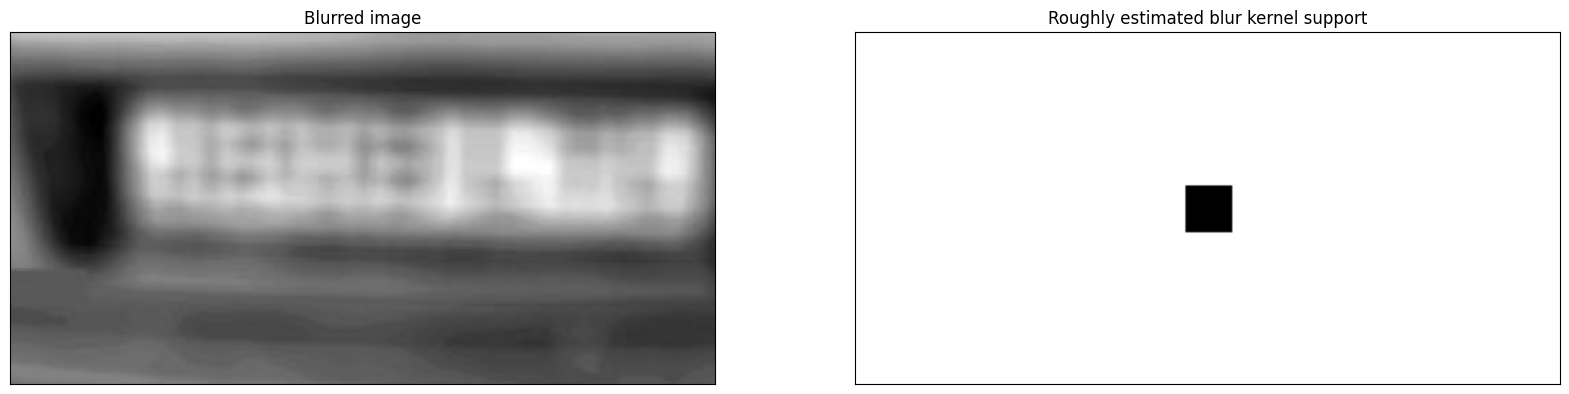

In [12]:
from lib.part1.deblur_lib import setup_show
setup_show()

###  Reformulating the problem

We now reformulate the blind image deconvolution problem, so that we can
apply the constrained optimization algorithms we have seen in the
course. Let ${\boldsymbol b}$ be the $L$-point normalized discrete
Fourier transform (DFT) of the observation $\textbf{y}$, i.e,
${\boldsymbol b}= \mathbf{F} \textbf{y}$, where $F$ is the DFT matrix.
Then, ${\boldsymbol b}$ can be written as
${\boldsymbol b}= {\boldsymbol A}({\bf X})$ where
${\bf X}= {\boldsymbol h}{\boldsymbol m}^\top$ and ${\boldsymbol A}$ is
a linear operator. Explicit expression of this linear operator
${\boldsymbol A}$ is out of the scope of this homework, c.f.,
[Ahmed2014](https://ieeexplore.ieee.org/document/6680763/) for further details. This reformulation allows us to
express $\textbf{y}$, which is a nonlinear combination of the
coefficients of ${\boldsymbol h}$ and ${\boldsymbol m}$, as a linear
combination of the entries of their outer product
${\bf X}= {\boldsymbol h}{\boldsymbol m}^\top$. Note that given
${\boldsymbol B}$ and ${\boldsymbol C}$, recovering ${\boldsymbol m}$
and ${\boldsymbol h}$ from ${\boldsymbol b}$ is the same as recovering
$\textbf{x}$ and ${\boldsymbol w}$ from $\textbf{y}$.

Since ${\bf X}$ is a rank one matrix, we can use the nuclear norm to
enforce approximately low-rank solutions. Then, we can formulate the
blind deconvolution problem as follows:
$$\begin{align}
{\boldsymbol X}^\star \in \arg \min_{ {\boldsymbol X}} \bigg\{ \frac{1}{2} \| \mathbf{A}({\boldsymbol X}) - {\boldsymbol b}\|_2^2 :  \| {\boldsymbol X}\|_\ast \leq \xi, ~{\boldsymbol X}\in \mathbb{R}^{p\times m}   \bigg\}, \tag{4}\label{eq:FWform}
\end{align}$$
where $\xi > 0$ is a tuning parameter.

Note that our problem is constrained to the nuclear norm ball
$\mathcal{X} = \{ {\boldsymbol X}: {\boldsymbol X}\in \mathbb{R}^{p \times m} , \| {\boldsymbol X}\|_\ast \leq \xi \}$.

We will apply the Frank-Wolfe algorithm to solve the optimization
problem given in \eqref{eq:FWform}. The Frank-Wolfe algorithm is one of the earliest
algorithms that avoids projections. Instead of projections, it leverages
lmos (for a very good survey see [Jaggi2013](https://proceedings.mlr.press/v28/jaggi13.html)):
$$\mathrm{lmo}(\nabla f ({\boldsymbol Z})) = \arg \min_{{\boldsymbol X}\in \mathcal{X}} ~ \langle \nabla f ({\boldsymbol Z}), {\boldsymbol X}\rangle,$$
where
$\mathcal{X} = \{ {\boldsymbol X}: \| {\boldsymbol X}\|_\ast \leq \xi, ~{\boldsymbol X}\in \mathbb{R}^{p\times m} \}$
as in Part 1. It applies to the generic constrained minimization
template with a smooth objective function,
$\min_{\boldsymbol X}\{ f({\boldsymbol X}) : {\boldsymbol X}\in \mathcal{X}, \, \mathcal{X} \text{ - convex, compact}  \}$
as follows:

----


### Frank-Wolfe's algorithm

1. Choose ${\boldsymbol X}^0 \in\mathcal{X}$.

2. For $k=0, 1, \ldots$ perform:
  $$\begin{cases}
  \hat{{\bf X}}^k &:= \mathrm{lmo}(\nabla f ({\boldsymbol X}^k)), \\
  {\bf X}^{k+1} &:= (1-\eta_k){\bf X}^k + \eta_k\hat{{\bf X}}^k,
  \end{cases}$$ where $\eta_k := {2}/{(k+2)}$

---



#### Question 1.5.1 (3 pts)

Recall that the Frank-Wolfe algorithm applies only for
    smooth objectives. Show that the objective function is smooth in the sense its gradient is Lipschitz continuous.

<font color="blue">
    
Our objective function is
$$
f(x) = \frac12 \|A(x) - b\|_2^2.
$$

We first compute its gradient. Consider the auxiliary function
$$
g(z) = \frac12 \|z - b\|_2^2.
$$
Its gradient is
$$
\nabla g(z) = z - b.
$$

By the chain rule, with $z = Ax$, we obtain
$$
\nabla f(x) = A^\ast (A(x) - b),
$$
where $A^\ast$ denotes the adjoint of $A$ (for a real matrix, $A^\ast = A^\top$).

To show that $\nabla f$ is Lipschitz, we estimate
$$
\|\nabla f(x) - \nabla f(y)\|_2
= \|A^\ast(A(x) - b) - A^\ast(A(y) - b)\|_2
= \|A^\ast A (x - y)\|_2.
$$

Using the operator norm inequality we have
$$
\|A^\ast A (x - y)\|_2 \le \|A^\ast A\|_2 \,\|x - y\|_2
= \|A\|_2^2 \,\|x - y\|_2.
$$

Therefore
$$
\|\nabla f(x) - \nabla f(y)\|_2
\le \|A\|_2^2 \,\|x - y\|_2,
$$
so the gradient of $f$ is $\|A\|_2^2$-Lipschitz, or $f$ is $\|A\|_2^2$-smooth.


### Implementation of Frank-Wolfe

Complete the missing lines of the Frank-Wolfe update below.
We provide you the linear operators that you need to compute the LMO in the code. Note that we do not need to
    store and use the linear operator ${\boldsymbol A}$ in the ambient
    dimensions. In fact, for storage and arithmetic efficiency, we
    should avoid explicitly writing ${\boldsymbol A}$. You can find more
    details about this aspect as comments in the code.

In [13]:
from lib.part1.deblur_lib import *

We will track three states:

- `X`: corresponding to $\boldsymbol X$
- `AX`: corresponding to $\boldsymbol{AX}$
- `k`: the iterate count

In [14]:
def init_state():
    return OptState(X=0.0, AX=0.0, k=1)

#### Question 1.5.2 (2 points) Complete the gradient computation of $f(\boldsymbol X)$
You have access to the following operators and variables:
    
- `A_T(Z)`: Computes $\boldsymbol A^\top \boldsymbol Z$ for some $\boldsymbol Z$.
- `Aoper`: Computes $\boldsymbol A \boldsymbol X$ for 1-rank matrix $\boldsymbol X$ using its SVD decomposition.
- `b`: corresponds to $\boldsymbol b$

**Remark**: The `grad` method will receive `AX` and not `X` for computational efficiency reasons.

In [15]:
f = Function(
    f = lambda AX: 0.5*np.linalg.norm(AX - b, 2)**2,
    grad = lambda AX: A_T(AX-b) # Fill
)

#### Question 1.5.3 (3 points) Complete the LMO

You are allowed to use `scipy`.

In [16]:
def lmo(Grad, xi=300):
    """ This function implements the lmo operator.
    """


    topLe_vec, s, topRe_vec = svds(Grad, k=1)
    # Fill
    Xhat = -xi * np.outer(topLe_vec, topRe_vec)

    # Apply A to the rank 1 update
    AXhat = Aoper(topLe_vec, -xi, topRe_vec.T)

    return (Xhat, AXhat)

#### Question 1.5.4 (4 points) Complete the Frank-Wolfe update

Fill in the missing update of `X` using the LMO from the previous exercise.

In [17]:
def state_update(f, state):
    X, AX, k = state

    Xhat, AXhat = lmo(f.grad(AX), xi = 300)

    # Step size
    eta_k = 2/(k+2)

    # Update X
    next_X = (1-eta_k)*X + eta_k * Xhat

    # Update A*X
    next_AX = (1.0-eta_k)*AX + eta_k*(AXhat)

    return OptState(next_X, next_AX, k+1)


In [18]:
opt_algorithm = OptAlgorithm("FrankWolfe", init_state, state_update)

#### Question 1.5.5 (3 points) Run Frank-Wolfe

Tune the
    parameter $\xi$ until the license plate number becomes readable.
    What is the license plate number?


  0%|          | 0/201 [00:00<?, ?it/s]

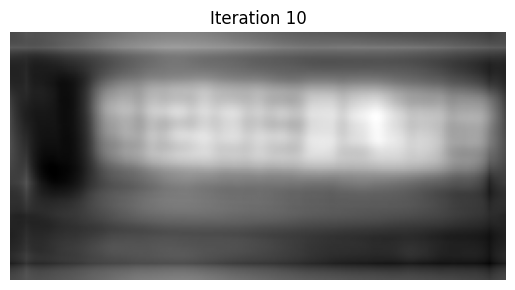

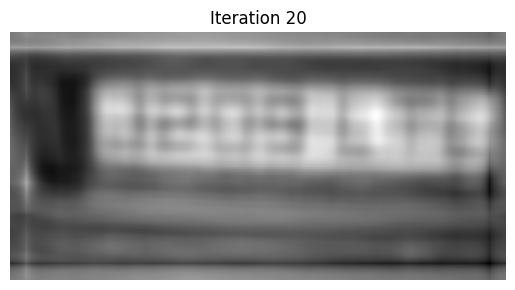

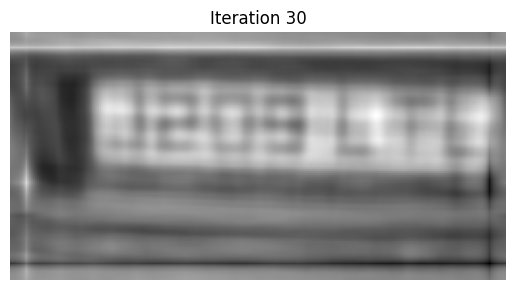

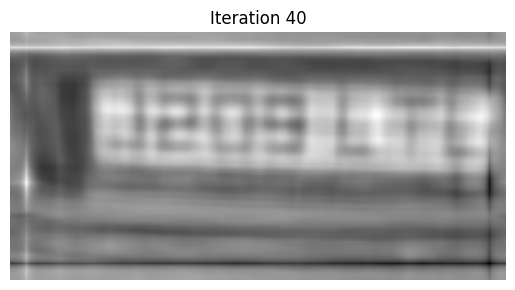

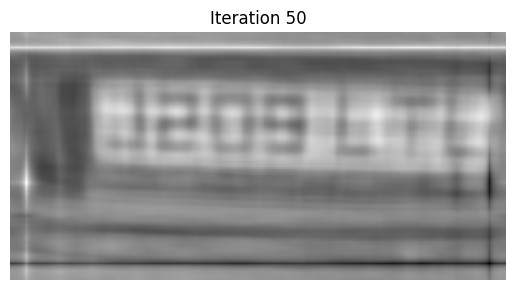

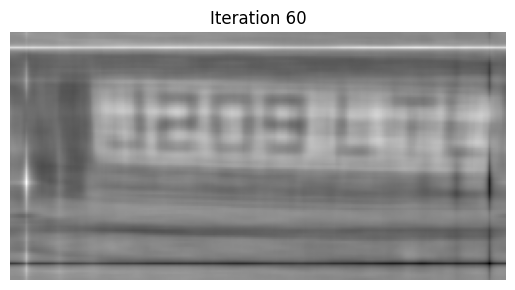

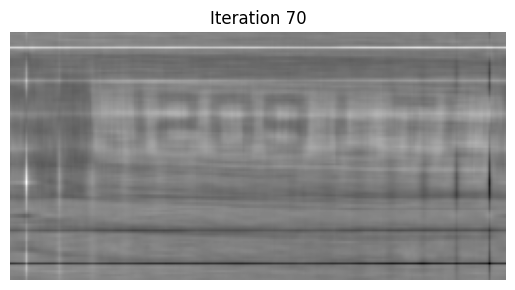

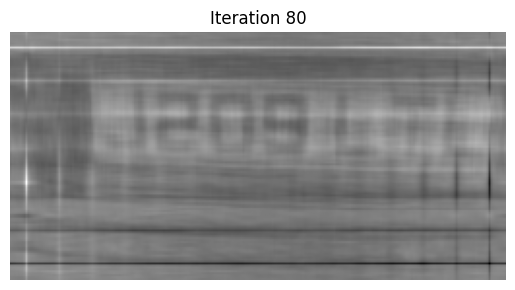

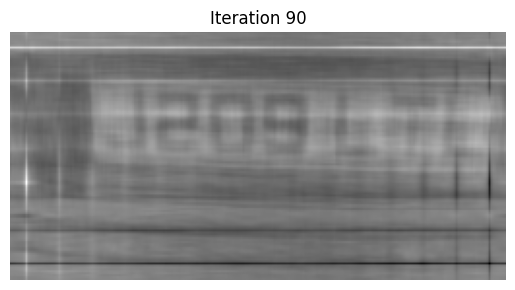

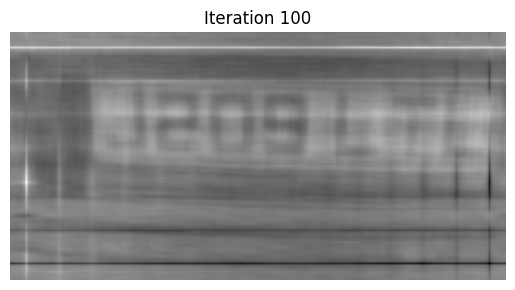

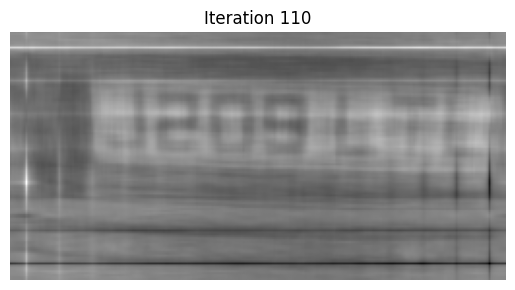

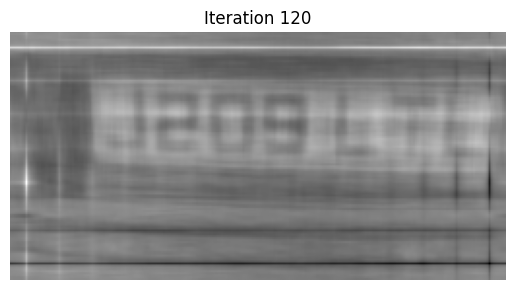

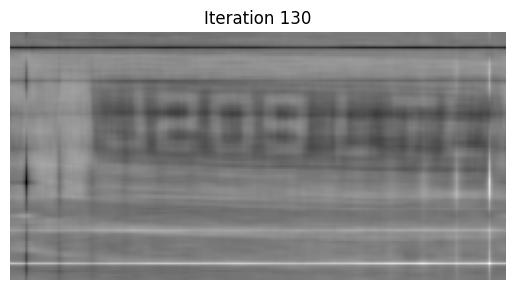

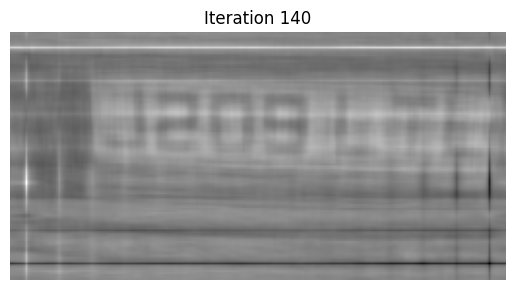

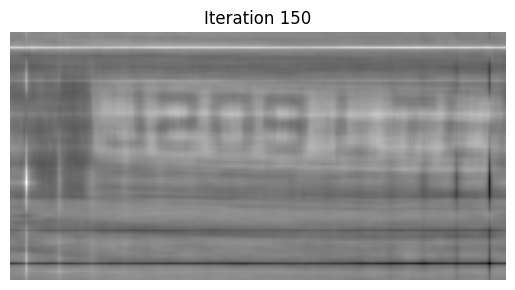

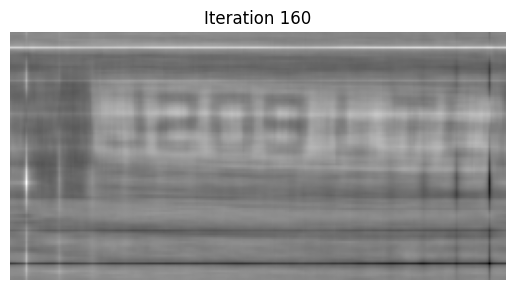

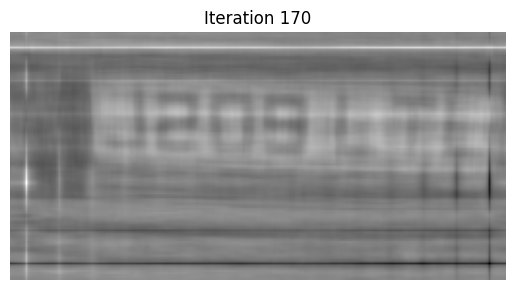

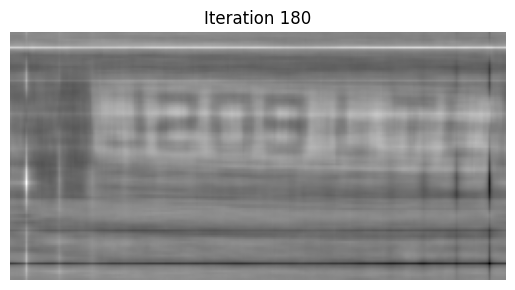

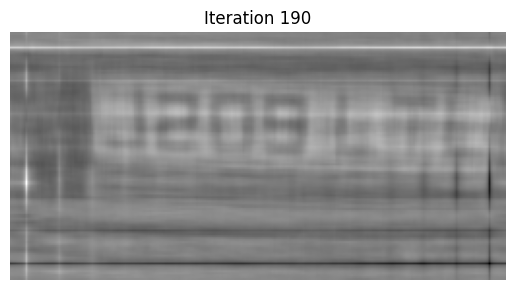

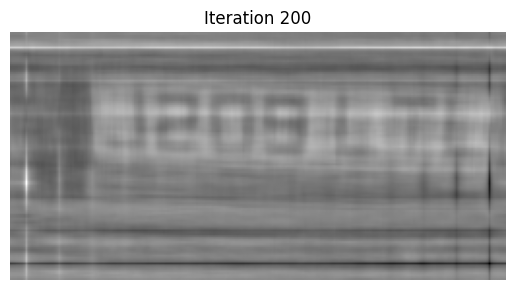

In [19]:
# Run Frank-Wolfe's method
xFW = run_frank_wolfe(f, opt_algorithm)

<font color="blue">
    
The licence plate is J209LTL.